# Running Keras

This tutorial will show you how to run Keras and how to train some simple recurrent neural networks. These can be useful for modeling, classifying, and predicting the results of sequence data. Keras is a lightweight simplified frontend to TensorFlow (Google's ML framework), ONTK, or MxNet.

## Getting / Installing

Keras (and Tensorflow) are available in pip, the python package manager. I'm using python3 here but they also work with python 2.  I did the following to set things up on a fairly standard debian stable system.  Some of these dependencies are for running 'jupyter', this nice(ish) web frontend for python code. 

    $ sudo apt-get install ipython3 python3-pip libopenblas-dev gfortran build-essential libzmq-dev graphviz 
    
This install ipython3 (a nice(ish) CLI for python3), the python3 package manager ('pip3'), a decently optimized BLAS library, and the fortran compiler.  build-essential is just basic build tools like gcc and make if you don't have them installed already.  libzmq-dev is only needed for jupyter. Next we'll install python packages into your local user directory:

    $ pip3 install --user --upgrade keras tensorflow graphviz pydot numpy jupyter
    
This will install Keras, Tensorflow, and their dependencies (some of which have to be specified manually). `jupyter` is just a web frontend and not necessary.  As part of this install, numpy and scipy will be compiled, which are the core linear algebra python libraries. 

With these you should have keras installed. Any binaries installed by these packages are located in `~/.local/bin`, so I add that to my PATH, but it may not be strictly necessary. 

## Configuring
Keras should now use Tensorflow by default.  If you want to use another backend, you'll need to adjust the config files in your home directory, specifically `.keras/keras.json`.  See https://keras.io/backend/ .

## Example RNN Problem Dataset

I'm including an example dataset which consists of 5000 input sequences (of length 100) of commands to a serial port UART. I've spent some time explaining this particular dataset and how it was generated.

In this dataset, the inputs are a vector `V` of floating point values that correspond to binary inputs to the 8 registers of a UART:

    V[0]     = command type (0.0 for read, 1.0 for write)
    V[1..3]  = target register (register 0-7 represented as 3 binary bits)
    V[4..11] = the 8-bit value to write to the register. 
    
This make every step in the sequence a vector of size 12 (encoded as float). Each sequence is 100 commands long, so each input sequence is a list of 100 of these vectors.  And since we want 5000 sequence examples, we wind up with a three-deep nested list of lists of 5000 lists of 100 entry lists of vectors of length 12. 

*Keras expects all input / outputs to be a 2D (non-sequence) or 3D (sequence) Numpy Array*. Fortunately, Numpy will happly convert a nested lists of lists into the rigth array for us, so the final input dataset if is a 3D numpy matrix of shape (5000, 100, 12). By convention we call these values X's.  

Note: People more expeerienced with Numpy can probably generate the array directly, but it's easier for me to do it in pure python and then have numy convert it for me.

Each input sequence has a corresponding output sequence. The output is the state of the UART after each command in the sequence is run  The vector there is:

    V[0..4]  = Parity (High/Low/Odd/Even/None) 1.0 for set value, 0 otherwise, only one set at a time (one-hot). 
    V[5..7]  = Stop bits (1, 1.5, 2) one-hot
    V[8..11] = Word length (5, 6, 7, 8) one-hot
    V[12]    = Baudrate.  A floating point value between 0.0-1.0 equivalent to <setting>/115200.0.  
    
So each output vector is size 13. With 5000 examples of 100 input sequences and turning that into a numpy 3D array, the final shape of the output set is (5000, 100, 13). 

The example inputs and output is pre-generated and included as a gzipped pickle file. By convention the inputs are called 'X', the outputs are called 'Y'.  So, to load:

In [1]:
import gzip
import pickle
import numpy as np

X, Y = pickle.load(gzip.open("dataset-serial.pgz"))

print("Inputs: " + str(X.shape))
print("Outputs: " + str(Y.shape))

Inputs: (5000, 100, 12)
Outputs: (5000, 100, 13)


We now have a set of input sequences (`X`) and associated output sequences (`Y`), which is what you need for training a neural network. 

## Building the Neural Network

First, include some preliminaries.  We'll be building a fairly simple sequential neural network.  We'll build one deep network without recurrent layers and one with recurrent layers with memory, and compare.  Keras has somewhat readable documentation 

### Import the necessary layers

In [2]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, TimeDistributed, LSTM, GRU
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


### Build and Training the first Dense model as a Baseline

Here we'll build a simple, classical fully connected neural network that works with sequence data. The model consists of an input layer of size 12 (input vector size) wrapped in TimeDistrbuted(), which is how the dense layer knows to expect a sequence, and not individual sets.  First, you create an empty Sequential model. It's called "Sequential" because the inputs flow in one direction, through the network layers, and to the output. 

In [5]:
model_dense = Sequential()
model_dense.add(TimeDistributed(Dense(X.shape[2]), input_shape=(X.shape[1],X.shape[2]))) # NOTE: X.shape[2] == 12
model_dense.add(TimeDistributed(Dense(14))) # Add a hidden layer with more nodes. 
model_dense.add(TimeDistributed(Dense(14))) # .. and another one! Cool, we're now into DEEP LEARNING!
model_dense.add(TimeDistributed(Dense(14))) # .. and another one! We've gone DEEPER!
model_dense.add(TimeDistributed(Dense(Y.shape[2]))) # Y.shape[2] == 13. This is our final, output layer
model_dense.compile(loss='mse',optimizer='nadam')

# Show a summary of the model
model_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, 100, 12)           156       
_________________________________________________________________
time_distributed_7 (TimeDist (None, 100, 14)           182       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 100, 14)           210       
_________________________________________________________________
time_distributed_9 (TimeDist (None, 100, 14)           210       
_________________________________________________________________
time_distributed_10 (TimeDis (None, 100, 13)           195       
Total params: 953
Trainable params: 953
Non-trainable params: 0
_________________________________________________________________


The above network is a 3-hidden layer deep fully connected sequence learning network. It's been compiled and ready to be trained.  It will attempt to optimize by minimizing the `mean squared error` (mse) of `loss`, where `loss` is defined as the average difference between the output of the network and the correct output for a particular bath.  In layman's terms.. how far the predicted result is from the actual result (squared).  It will optimize the search for 'less loss' using the `nadam` algorithm. Which is complicated to explain, but good optimiser to use for sequence learning. 

This is a classic neural network from the 80s modified to work with sequences.  Now the fun begins, training on the data.  We'll tell the model to set aside 10% of the input dataset to use for 'validation', so it will NOT be used to train the network itself. It will *only* be used to test how well the network is doing at each step. The training process has a few parameters:

* epochs : Each epoch is one trhip through the entire training dataset. The performance of the network is compared against the validation set at the end of each epoch.  Setting the number of epochs means setting the number of times the training phase will process the dataset. 
             
* batch size : While walking through the dataset, the model is tuned after 'batch size' entries are processed. So a batch_size of 10 means that the network processes 10 entries, calculates the loss, an updates the weights, and then processes 10 more, etc.  This is an tradeoff, a batchsize of 1 might be more accurate but it much slower and could potentially overfit, a batch size of 1000 would run very fast but loss is calculated as the *average over the batch size*, so many details will be lost on the average.
                 
Lets train our neural network with a batch size of 10 for 10 epochs, keeping 10% of the data aside for splitting. Note that for this dataset, a batchsize of 10 might not be ideal, but for most it's a reasonable default. 

In [6]:
hist = model_dense.fit(X, Y, batch_size=10, epochs=10, validation_split=0.10, verbose=1)

Train on 4500 samples, validate on 500 samples
Epoch 1/10
4500/4500 [==============================] - 2s 456us/step - loss: 0.1720 - val_loss: 0.1667
Epoch 2/10
4500/4500 [==============================] - 2s 367us/step - loss: 0.1661 - val_loss: 0.1671
Epoch 3/10
4500/4500 [==============================] - 2s 367us/step - loss: 0.1660 - val_loss: 0.1667
Epoch 4/10
4500/4500 [==============================] - 2s 356us/step - loss: 0.1659 - val_loss: 0.1665
Epoch 5/10
4500/4500 [==============================] - 2s 368us/step - loss: 0.1658 - val_loss: 0.1667
Epoch 6/10
4500/4500 [==============================] - 2s 353us/step - loss: 0.1657 - val_loss: 0.1663
Epoch 7/10
4500/4500 [==============================] - 2s 355us/step - loss: 0.1657 - val_loss: 0.1661
Epoch 8/10
4500/4500 [==============================] - 2s 356us/step - loss: 0.1657 - val_loss: 0.1666
Epoch 9/10
4500/4500 [==============================] - 2s 368us/step - loss: 0.1657 - val_loss: 0.1664
Epoch 10/10
4500/

So in this case, the "loss" (loss over the training data) for better for the first few epochs, but then settled at about 0.16, which is not good, In general, it is better to concentrate on the *loss*, as that is a measure of how far away you are from the target value. 

This makes sense since even a deep network like this has no recurrence, and no memory of what happened earlier in the sequence. Lets plot the loss over time:

Text(0, 0.5, 'loss')

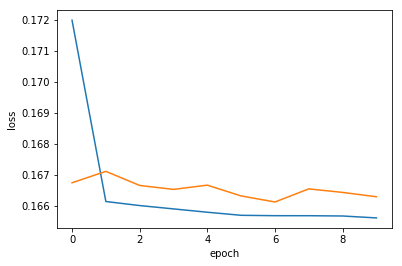

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.subplot(111)
plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel("epoch")
plt.ylabel("loss")


So, overall, not very good. We can do a lot better.  

To test a new input against the model we've trained, you can use the *predict()* method of the model:

In [8]:
from gen_lstm_serial_input import gen_dataset

new_X, new_Y = gen_dataset(None, 100, 1) # NOTE: this function returns a dataset of size 1. 
new_X.shape

(1, 100, 12)

In [9]:
new_X[0], new_Y[0]

(array([[1., 1., 0., ..., 0., 1., 1.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.]]),
 array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        ...,
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         1.00000000e+00, 0.00000000e+00, 2.77777778e-04],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         1.00000000e+00, 0.00000000e+00, 2.77777778e-04],
        [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
         1.00000000e+00, 0.00000000e+00, 2.77777778e-04]]))

In [10]:
Ypred = model_dense.predict(new_X)[0]
Ypred

array([[0.51621705, 0.11647419, 0.15576352, ..., 0.06518978, 0.28873545,
        0.428908  ],
       [0.5853808 , 0.10337713, 0.11776035, ..., 0.11516039, 0.30486354,
        0.4432791 ],
       [0.5853808 , 0.10337713, 0.11776035, ..., 0.11516039, 0.30486354,
        0.4432791 ],
       ...,
       [0.5018794 , 0.12142556, 0.16049524, ..., 0.09253278, 0.25608274,
        0.4060949 ],
       [0.58518964, 0.10122536, 0.10526008, ..., 0.11296521, 0.30270573,
        0.43282622],
       [0.5854172 , 0.10395668, 0.10828036, ..., 0.11481233, 0.3084122 ,
        0.46273154]], dtype=float32)

We have a predicted sequence, and we have the real output sequence.  The predicted sequence is 100x13, so a total of 1300 entries to get right.  Lets take the difference between the prediced and actual, and see how many entries got within 10% of the real answer:

In [11]:
diff = new_Y[0] - Ypred
np.abs(diff)
len(np.where(diff < 0.1)[0])

986

So in the end, we're able to predict, within 10%, the above number of entries out of 1300 entries total.

------

## Recurrence and Memory

Sequences almost always require knowledge of what happened previously in the sequence to make a proper prediction of how the system should react to the current input.  This means networks need to have some notion of *memory*.  The first attempts to do this Neural Networks was to simply hook the output of the network back to the input, making the current output state of the network also the input state. More sophisticated solutions use more complicated mechanisms at each node in the NN graph, which contain some loopback onto itself, and train a weight parameter to determine both what should be "saved" in this memory, and how much what's currently in the memory should effect the output of node at the current time.  Two of these node types are called 'Long Short Term Memory' (LSTMs) and Gated Recurrent Units (GRUs).  They are beyond the purpose of this tutorial, but suffice it to say they make your network much more powerful by adding memory.  Nearly all current sequence learning tasks use these types of nodes in some way or another. GRUs are slightly faster to train, but may have trouble remembering longer sequences.  I'll stick with LSTM's here.

### Building an LSTM net

The basic steps are the same as before, except instead of using "TimeDistributed(Dense())" nodes, we use LSTM nodes, whcih Keras helpfully provides:

In [12]:
model_lstm = Sequential()
model_lstm.add(LSTM(X.shape[2], input_dim=X.shape[2], input_length=X.shape[1], return_sequences=True))
model_lstm.add(LSTM(max(X.shape[2],Y.shape[2])+1, return_sequences=True))
model_lstm.add(LSTM(max(X.shape[2],Y.shape[2])+1, return_sequences=True))
model_lstm.add(LSTM(max(X.shape[2],Y.shape[2])+1, return_sequences=True))
model_lstm.add(TimeDistributed(Dense(Y.shape[2])))
model_lstm.compile(loss='mse',optimizer='nadam')

# Show a summary of the model
model_lstm.summary()

/home/john/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/home/john/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(12, return_sequences=True, input_shape=(100, 12))`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 12)           1200      
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 14)           1512      
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 14)           1624      
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 14)           1624      
_________________________________________________________________
time_distributed_11 (TimeDis (None, 100, 13)           195       
Total params: 6,155
Trainable params: 6,155
Non-trainable params: 0
_________________________________________________________________


This is a 5-layer deep (4 hidden layer, 3 LSTM + 1 Dense) LSTM deep learning network. I've awats added a final Dense layer at the end to make the correct number of outputs, I believe this is necessary.  Now, lets train this model and see how it does compared to the previous dense model:

In [13]:
hist_lstm = model_lstm.fit(X, Y, batch_size=10, epochs=10, validation_split=0.10, verbose=1)

Train on 4500 samples, validate on 500 samples
Epoch 1/10
4500/4500 [==============================] - 105s 23ms/step - loss: 0.1656 - val_loss: 0.1588
Epoch 2/10
4500/4500 [==============================] - 102s 23ms/step - loss: 0.1572 - val_loss: 0.1576
Epoch 3/10
4500/4500 [==============================] - 102s 23ms/step - loss: 0.1546 - val_loss: 0.1519
Epoch 4/10
4500/4500 [==============================] - 103s 23ms/step - loss: 0.1491 - val_loss: 0.1467
Epoch 5/10
4500/4500 [==============================] - 103s 23ms/step - loss: 0.1436 - val_loss: 0.1421
Epoch 6/10
4500/4500 [==============================] - 104s 23ms/step - loss: 0.1346 - val_loss: 0.1325
Epoch 7/10
4500/4500 [==============================] - 104s 23ms/step - loss: 0.1219 - val_loss: 0.1184
Epoch 8/10
4500/4500 [==============================] - 104s 23ms/step - loss: 0.1130 - val_loss: 0.1117
Epoch 9/10
4500/4500 [==============================] - 105s 23ms/step - loss: 0.1037 - val_loss: 0.0965
Epoch 10

Clearly, this time the loss on both the trainign set and the validation set are decreasing, and continuing to decrease. This indicates that training for more epochs would get even better results.  Keras will happily continue training a model later (calling model_lstm.fit now for 10 more epochs will continue where it left off).  You can save a model and it's trained weights to reload loater and confinue training (model.save() ?).  

For now, we'll leave this at 10 epochs and compare to the dense model 

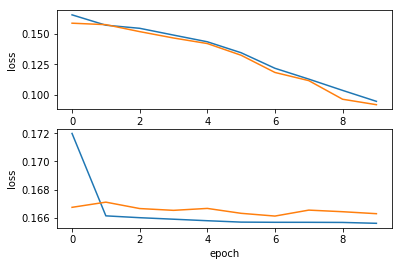

In [17]:
plt.subplot(211)
plt.plot(hist_lstm.history['loss'], label='training')
plt.plot(hist_lstm.history['val_loss'], label='validation')
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(212)
plt.plot(hist.history['loss'], label='training')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

And now, lets see how we do with predicting the same new sequence we used for dense. The same parameters apply, its 1300 values to get right. 

In [18]:
Ypred = model_lstm.predict(new_X)[0]
Ypred

array([[ 1.0410596 , -0.02245665, -0.00512156, ..., -0.08183676,
        -0.02729367,  0.9800962 ],
       [ 1.0033237 , -0.01798886, -0.00671758, ..., -0.04138784,
        -0.01109394,  1.0166408 ],
       [ 0.9812635 , -0.00608682, -0.00227278, ..., -0.01045166,
         0.00621396,  1.015512  ],
       ...,
       [ 0.44039443,  0.14830127,  0.12078165, ...,  0.9263835 ,
         0.09470329,  0.05239069],
       [ 0.4387894 ,  0.14824398,  0.12171061, ...,  0.9178715 ,
         0.10104816,  0.05036294],
       [ 0.43643394,  0.1475285 ,  0.12138777, ...,  0.9252206 ,
         0.08284989,  0.0478788 ]], dtype=float32)

In [19]:
diff = new_Y[0] - Ypred
np.abs(diff)
len(np.where(diff < 0.1)[0])

1120

And we see we've done better at least on our one test case.  We could continue to train each model for more epochs, but I can assure you that the LSTM will keep getting better for a while, while the dense one will likely not change much. 

# Summary

At the end of this tutorial I hope you have learned at least the following things:

* How to install Keras and Theano
* What goes into preparing a set of inputs and outputs for use in a neural network
* How to use Keras and Theano to construct different neural network topologies
* To to train these networks using training and validation data
* How to use the model to predict a new, unseen result
* A little bit about how to evaluate the performance of each model.

Feel free to contact me (John Clemens) with any questions. 

# Appendix

Lets train the LSTM model up to 50 epochs and see what happens. 


In [20]:
hist_lstm_10_50 = model_lstm.fit(X, Y, batch_size=10, epochs=40, validation_split=0.10, verbose=2)

Train on 4500 samples, validate on 500 samples
Epoch 1/40
 - 101s - loss: 0.0899 - val_loss: 0.0887
Epoch 2/40
 - 101s - loss: 0.0860 - val_loss: 0.0881
Epoch 3/40
 - 100s - loss: 0.0816 - val_loss: 0.0787
Epoch 4/40
 - 103s - loss: 0.0730 - val_loss: 0.0686
Epoch 5/40
 - 101s - loss: 0.0653 - val_loss: 0.0624
Epoch 6/40
 - 101s - loss: 0.0599 - val_loss: 0.0583
Epoch 7/40
 - 101s - loss: 0.0569 - val_loss: 0.0549
Epoch 8/40
 - 103s - loss: 0.0546 - val_loss: 0.0538
Epoch 9/40
 - 103s - loss: 0.0527 - val_loss: 0.0522
Epoch 10/40
 - 101s - loss: 0.0517 - val_loss: 0.0512
Epoch 11/40
 - 100s - loss: 0.0516 - val_loss: 0.0506
Epoch 12/40
 - 100s - loss: 0.0504 - val_loss: 0.0504
Epoch 13/40
 - 100s - loss: 0.0498 - val_loss: 0.0505
Epoch 14/40
 - 100s - loss: 0.0498 - val_loss: 0.0495
Epoch 15/40
 - 100s - loss: 0.0489 - val_loss: 0.0489
Epoch 16/40
 - 100s - loss: 0.0486 - val_loss: 0.0486
Epoch 17/40
 - 100s - loss: 0.0478 - val_loss: 0.0413
Epoch 18/40
 - 104s - loss: 0.0373 - val_los

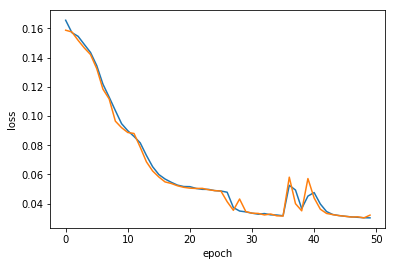

In [21]:
plt.subplot(111)
plt.plot(hist_lstm.history['loss'] + hist_lstm_10_50.history['loss'], label='training')
plt.plot(hist_lstm.history['val_loss'] + hist_lstm_10_50.history['val_loss'], label='validation')
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()

In [22]:
Ypred = model_lstm.predict(new_X)[0]
diff = new_Y[0] - Ypred
np.abs(diff)
len(np.where(diff < 0.1)[0])

1247

Wow, this time we've got all but 2 entries withing 10% of the real value. 